In [2]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import plotly.express as px
import math
import os


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA,IncrementalPCA

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [3]:
# Load data 
df = pd.read_excel('WonderfulWinesoftheWorld.xlsx')

In [4]:
#drop useless columns
df.drop(columns = ['Rand','Custid'],inplace = True)

### Data exploration

In [5]:
df.iloc[:, 20:].describe()

In [6]:
nullsCol = df.isna().sum()
nullsCol # THERE IS NOT NULLS

In [7]:
# Preserving the original df
df_clean = df.copy()
df_clean.dropna(inplace = True) #drop because teenhome= 0.4698, kidhome = 0.4188, SMRack = 817, SPcork = 682, Bucket = 130

# Check duplicated observations
df_clean.loc[df_clean.duplicated(keep=False), :]

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Kidhome, Teenhome, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit, SMRack, LGRack, Humid, Spcork, Bucket, Access, Complain, Mailfriend, Emailfriend]
Index: []

[0 rows x 28 columns]

In [8]:
hist1 = px.histogram(df, x=df['Age'], color_discrete_sequence=['darkseagreen'], template='plotly_white')
hist1.show()

In [116]:

# Removing outliers from the dataset
df_clean = df_clean.loc[df_clean['Sweetred']<52, :]
df_clean = df_clean.loc[df_clean['LTV']<1520, :]
df_clean = df_clean.loc[df_clean['Sweetwh']<51, :]
df_clean = df_clean.loc[df_clean['Dessert']<50, :]
df_clean = df_clean.loc[df_clean['WebPurchase']<87, :]
df_clean = df_clean.loc[df_clean['SMRack']<3, :]



### Feature Engineering 

In [117]:
#creating a variable to join all the Accessories money spent

df_clean["SMRack"] = df["SMRack"].map({0:0,1:50})
df_clean["LGRack"] = df["LGRack"].map({0:0,1:100})
df_clean["Humid"] = df["Humid"].map({0:0,1:75})
df_clean["Spcork"] = df["Spcork"].map({0:0,1:60})
df_clean["Bucket"] = df["Bucket"].map({0:0,1:150})

df_clean['Accessories'] = df_clean['SMRack'] + df_clean['LGRack'] + df_clean['Humid'] + df_clean['Spcork'] + df_clean['Bucket']




In [118]:
df_clean.drop(columns = ['SMRack','LGRack','Humid','Spcork','Bucket','Access'],inplace = True)

In [119]:
#check datatypes
df_clean.dtypes

Dayswus        float64
Age            float64
Edu            float64
Income         float64
Kidhome        float64
Teenhome       float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
Complain         int64
Mailfriend       int64
Emailfriend      int64
Accessories    float64
dtype: object

In [120]:
#df_clean['Spend Rate'] = df_clean['Monetary'] / df_clean['Freq']

In [121]:
#df_clean['Web Spend Rate'] = df_clean['WebPurchase'] / df_clean['WebVisit']

In [122]:
# joining kid 
df_clean['Kidhome'] = df_clean['Kidhome'].astype(int) 
df_clean['Teenhome'] = df_clean['Teenhome'].astype(int) 

df_clean['Dependents'] =  df_clean['Kidhome']+df_clean['Teenhome']
df_clean['Dependents'] = df_clean.Dependents.map({1:1,0:0,2:1})
df_clean.drop(columns = ['Kidhome','Teenhome'],inplace = True)

In [123]:
non_metric_features = ['Complain','Mailfriend','Emailfriend','Dependents']
metric_features = df_clean.columns.drop(non_metric_features).to_list()

In [131]:
#creating a dataset for categorical variables to a later analysis
df_categorical = df_clean[non_metric_features]
df_categorical.reset_index(drop = True, inplace = True)

### Feature Selection Correlations

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x115790250>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x115790250>
Setting pcolormesh
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (

findfont: score(<Font 'Trebuchet MS' (Trebuchet MS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal light normal>) = 10.24
findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNSDisplay-SemiboldItalic.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal regular normal>) = 10.05
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
findfont: score(<Font 'Al 

findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF Compact Text' (SFCompactText-RegularItalic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05
findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 7.698636363636363
findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Avenir' (Aveni

findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 4.971363636363637
findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<F

Text(0.5, 0.98, 'Spearman Correlation Matrix')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoS

findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNSDisplay-SemiboldItalic.otf) italic normal semibold normal>) = 11.24
findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal regular normal>) = 10.05
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Iowan Old St

findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05
findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 7.698636363636363
findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
findfont: score(<Font 'System Font' (SFNSText.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Light.otf) 

findfont: score(<Font 'Oriya Sangam MN' (Oriya Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (Verdana Bold Italic.ttf) italic normal 700 normal>) = 4.971363636363637
findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Bold.otf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Pa

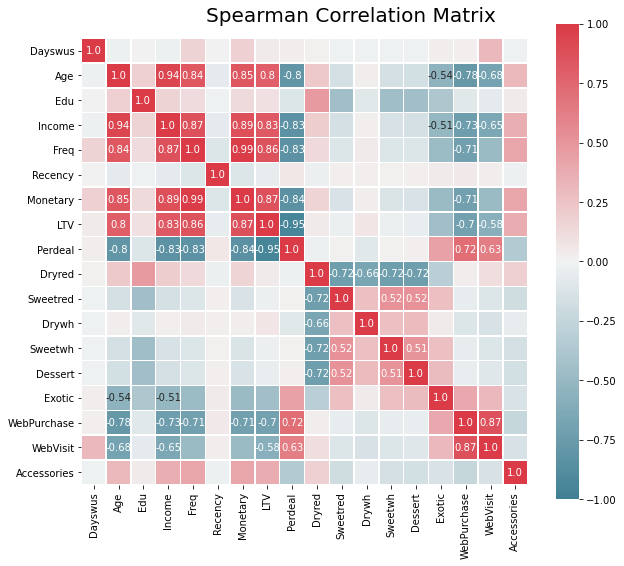

In [16]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_clean[metric_features].corr(method='spearman'), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Spearman Correlation Matrix", fontsize=20)


In [17]:
#corr['WebVisit'].sort_values(ascending=False)

In [18]:
#corr['WebPurchase'].sort_values(ascending=False)

#### Intrepertar as correlacoes para fazer apresentacao 

In [19]:
df_cluster = df_clean.copy()

In [20]:
#drop due to high correlation
df_cluster.drop(columns = ['Income', 'Freq','LTV','WebPurchase','Perdeal'],inplace = True) 
#drop since its categorical
df_cluster.drop(columns = ['Complain','Mailfriend','Emailfriend','Dependents'],inplace = True) 



In [21]:
df_cluster.columns

Index(['Dayswus', 'Age', 'Edu', 'Recency', 'Monetary', 'Dryred', 'Sweetred',
       'Drywh', 'Sweetwh', 'Dessert', 'Exotic', 'WebVisit', 'Accessories'],
      dtype='object')

## Normalize 

In [22]:

df_minmax = df_cluster.copy()

In [23]:
# df_minmax['Spend Rate']= round((df_minmax['Spend Rate']),2)
# df_minmax['Web Spend Rate']= round((df_minmax['Web Spend Rate']),2)



In [24]:
df_minmax.reset_index(drop = True, inplace = True)

In [25]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax)
#scaled_feat

In [26]:
metric_features = df_minmax.columns.to_list()

In [27]:
df_minmax[metric_features] = scaled_feat

In [28]:
df = df_minmax


### PCA

We didnt use PCA since it didnt help the interpretability of the clusters

In [29]:
#df_pca = df_minmax.copy()

In [30]:
# # # Use PCA to reduce dimensionality of data
# pca = PCA()
# pca_feat = pca.fit_transform(df_pca[metric_features])
# #pca_feat  # What is this output?

In [31]:
# # Output PCA table
# pca_table = pd.DataFrame(
#      {"Eigenvalue": pca.explained_variance_,
#       "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
#       "Proportion": pca.explained_variance_ratio_,
#       "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
#      index=range(1, pca.n_components_ + 1)
#  )

In [32]:
#df_pca[metric_features].var().sum()/df_pca[metric_features].shape[1]

#Treshold do pearson

In [33]:
#pca_table.head(10)

In [34]:
# # # figure and axes
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(60, 5))

# # # draw plots
# ax1.plot(pca.explained_variance_[0:100], marker=".", markersize=12)
# ax2.plot(pca.explained_variance_ratio_[0:100], marker=".", markersize=12, label="Proportion")
# ax2.plot(np.cumsum(pca.explained_variance_ratio_[0:100]), marker=".", markersize=12, linestyle="--", label="Cumulative")

# # # customizations
# ax2.legend()
# ax1.set_title("Scree Plot", fontsize=14)
# ax2.set_title("Variance Explained", fontsize=14)
# ax1.set_ylabel("Eigenvalue")
# ax2.set_ylabel("Proportion")
# ax1.set_xlabel("Components")
# ax2.set_xlabel("Components")
# ax1.set_xticks(range(0, pca.n_components_-97, 2))
# ax1.set_xticklabels(range(1, pca.n_components_ -97+ 1, 2))
# ax2.set_xticks(range(0, pca.n_components_-97, 2))
# ax2.set_xticklabels(range(1, pca.n_components_-97 + 1, 2))

# plt.show()

In [35]:
# # # Perform PCA again with the number of principal components you want to retain
# pca = IncrementalPCA(n_components=4)
# pca_feat = pca.fit_transform(df_pca[metric_features])
# pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
# pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
# pca_df

In [36]:
# # # Reassigning df to contain pca variables
# df_pca = pd.concat([df_pca, pca_df], axis=1)
# df_pca.head()

In [37]:
# def _color_red_or_green(val):
#     if val < -0.55:
#         color = 'background-color: red'
#     elif val > 0.55:
#         color = 'background-color: green'
#     else:
#         color = ''
#     return color

# # Interpreting each Principal Component
# loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
# loadings.style.applymap(_color_red_or_green)

# Perspectives 

### Client value - Daywus,LTV,Recency, WebVisit
### Demographic - Age,Edu
### Products - Dryred,Sweetred,Drywh,Sweetwh,Dessert, Exotic,Accessories


### Client Value

In [38]:
Client_value = ['Dayswus','Monetary','Recency','WebVisit']


SOM + Hierachical CLustering

https://www.researchgate.net/post/How-many-nodes-for-self-organizing-maps

According to Jing Tian et al. (find paper attached) you can use the following equation:
M ≈ 5 sqrt(N)

In [39]:
5*math.sqrt(10000)

500.0

In [40]:
#Set the random seed
np.random.seed(42)

#Perform the SOM
sm = sompy.SOMFactory().build(
    df[Client_value].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=Client_value
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)



 Training...
 random_initialization took: 0.030000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.794000, quantization error: 0.450162

 epoch: 2 ---> elapsed time:  0.504000, quantization error: 1.812274

 epoch: 3 ---> elapsed time:  0.464000, quantization error: 1.766424

 epoch: 4 ---> elapsed time:  0.677000, quantization error: 1.760803

 epoch: 5 ---> elapsed time:  0.644000, quantization error: 1.758609

 epoch: 6 ---> elapsed time:  0.702000, quantization error: 1.757290

 epoch: 7 ---> elapsed time:  0.615000, quantization error: 1.756270

 epoch: 8 ---> elapsed time:  0.570000, quantization error: 1.755223

 epoch: 9 ---> elapsed time:  0.523000, quantization error: 1.754146

 epoch: 10 ---> elapsed time:  0.485000, quantization error: 1.753053

 epoch: 11 ---> elapsed time:  0.563000, quantization error: 1.751938

 epoch: 12 ---> elapsed time:  0.555000, quantization error: 1.750794

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.453000, quantization error: 1.100453

 epoch: 15 ---> elapsed time:  0.438000, quantization error: 1.093641

 epoch: 16 ---> elapsed time:  0.426000, quantization error: 1.086732

 epoch: 17 ---> elapsed time:  0.424000, quantization error: 1.079775

 epoch: 18 ---> elapsed time:  0.422000, quantization error: 1.072715

 epoch: 19 ---> elapsed time:  0.418000, quantization error: 1.065574

 epoch: 20 ---> elapsed time:  0.425000, quantization error: 1.058375

 epoch: 21 ---> elapsed time:  0.444000, quantization error: 1.051104

 epoch: 22 ---> elapsed time:  0.413000, quantization error: 1.043766

 epoch: 23 ---> elapsed time:  0.426000, quantization error: 1.036289

 epoch: 24 ---> elapsed time:  0.432000, quantization error: 1.028607

 epoch: 25 ---> elapsed time:  0.431000, quantization error: 1.020791

 epoch: 26 ---> elapsed time:  0.456000, quantization error: 1.012828

 epoch: 27 ---> elapsed time:  0.426000, quantization error: 1.004780

 epoch

In [41]:
# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

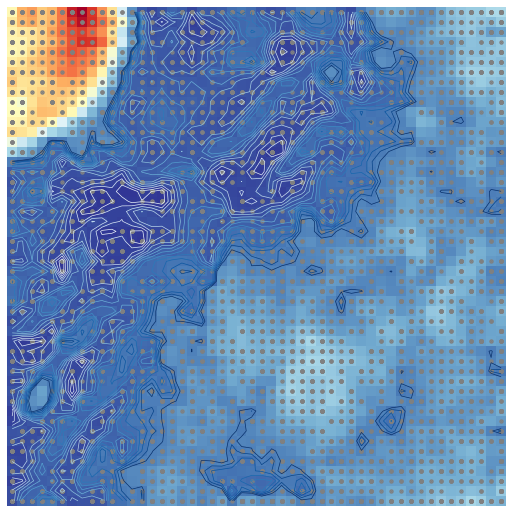

In [42]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=True, 
    contooor=True, # Visualize isomorphic curves
    blob=False
)

#UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values 

In [43]:
#Obtaining SOM's BMUs labels
Value_SOM = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1), 
                             index=df.index, 
                             columns=np.append(df[Client_value].columns,"SOM Labels- Client Value"))

In [44]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

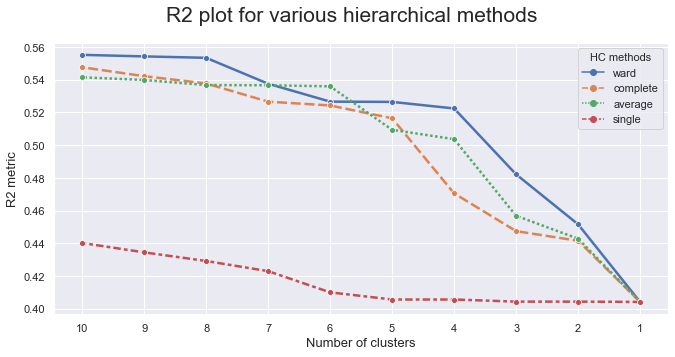

In [45]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = Value_SOM.groupby("SOM Labels- Client Value").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=som_units, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

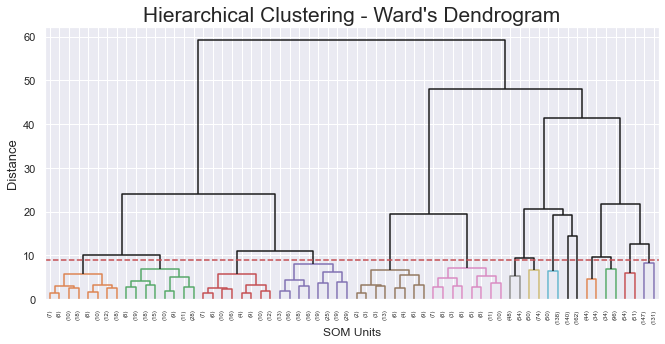

In [46]:
#Hierarchical clustering 
Z= linkage(som_units, method='ward')

sns.set()
fig = plt.figure(figsize=(11,5))

# Dendrogram 
dendrogram(Z, truncate_mode='level', p=5, color_threshold=9, above_threshold_color='k')
plt.hlines(9, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Ward\'s Dendrogram', fontsize=21)
plt.xlabel('SOM Units')
plt.ylabel('Distance', fontsize=13)
plt.show()

In [47]:
# Perform Hierarchical clustering
hierclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels = hierclust.fit_predict(som_units)


In [48]:
# Obtaining HC labels for each SOM unit
hc_som_units = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(nodeclus_labels,1)), axis=1),
index=som_units.index, columns=np.append(som_units.columns,["SOM Labels Client Value HC 3"]))

# Get cluster labels for each observation
df_final_a = Value_SOM.merge(right=hc_som_units.loc[:,"SOM Labels Client Value HC 3"],
left_on="SOM Labels- Client Value", right_index=True).sort_index()
df_final_a

Dayswus  Monetary   Recency  WebVisit  SOM Labels- Client Value  \
0    -1.210125  0.313276 -0.635905 -0.090622                    1826.0   
1     0.707111  1.902241 -0.420569 -0.519646                    1249.0   
2    -1.145888 -0.905550 -0.090388  1.196447                    1100.0   
3     0.746642 -0.908647 -0.233945  0.767424                     678.0   
4    -0.300920 -0.910196 -0.851240  0.338401                    1409.0   
...        ...       ...       ...       ...                       ...   
9951  1.156772  0.235841 -0.047321 -0.519646                    1093.0   
9952 -1.491781  0.149114 -0.248301 -1.377692                    2318.0   
9953 -1.378130 -0.893160  0.038813 -0.090622                    2153.0   
9954  1.033239 -0.942718  4.388591  0.338401                       5.0   
9955  0.400748  0.811957 -0.492348 -0.090622                    1432.0   

      SOM Labels Client Value HC 3  
0                              0.0  
1                              1.0  
2                              0.0  
3                              0.0  
4                              0.0  
...                            ...  
9951                           0.0  
9952                           1.0  
9953                           0.0  
9954                           2.0  
9955                           0.0  

[9956 rows x 6 columns]

In [49]:
# Number of observations in each cluster
df_final_a['SOM Labels Client Value HC 3'].value_counts()

0.0    7134
1.0    2408
2.0     414
Name: SOM Labels Client Value HC 3, dtype: int64

In [50]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

In [51]:
sst = get_ss(df_final_a.drop(columns=['SOM Labels Client Value HC 3'])) 
ssw_labels = df_final_a[df_final_a.drop(columns=['SOM Labels Client Value HC 3']).columns.to_list() + ["SOM Labels Client Value HC 3"]].groupby(by='SOM Labels Client Value HC 3').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.3900615251933877

In [52]:
# Characterizing the final clusters
clusters_Value= df_final_a.drop(columns="SOM Labels- Client Value").groupby("SOM Labels Client Value HC 3").mean()
clusters_Value

Dayswus  Monetary   Recency  WebVisit
SOM Labels Client Value HC 3                                        
0.0                           0.030276 -0.384593 -0.173866  0.393066
1.0                          -0.053946  1.301182 -0.174865 -1.261172
2.0                          -0.207942 -0.940964  4.013124  0.562239

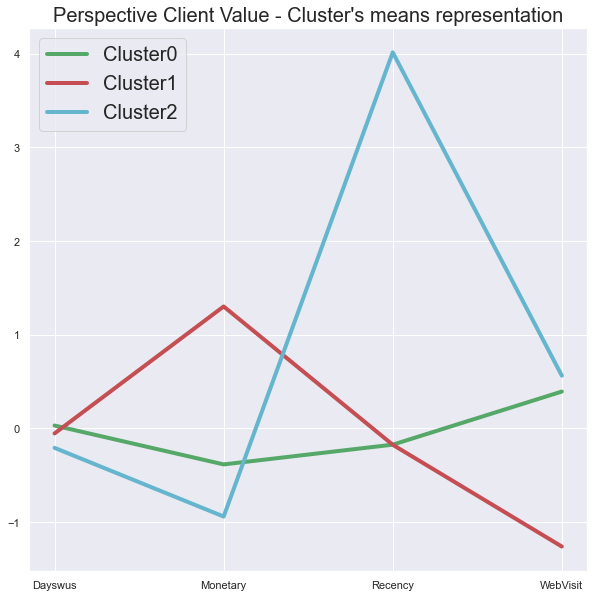

In [53]:
#Plot for each cluster the average values of each variable in in this perspective
sns.set()
plt.figure(figsize=(10,10))

colors = ["g","r","c","b",'y']
for value in range(0,3):
    plt.plot(clusters_Value.columns,clusters_Value.loc[value, clusters_Value.columns], color=colors[value], linewidth=4, label='Cluster'+ str(value))
plt.legend(prop={'size':20})
plt.title('Perspective Client Value - Cluster\'s means representation', fontsize=20)
#plt.savefig(os.path.join(os.getcwd(), 'figures', 'exp_analysis', 'Clusters_means_ClientValue.png'), dpi=200)
plt.show()

In [54]:
def _color_red_or_green(val):
    if val <= 0.4:
        color = 'background-color: mistyrose'
    elif val > 0.4 and val <= 0.65:
        color = 'background-color: darksalmon'
    else:
        color = 'background-color: tomato'  

    return color

In [55]:
clusters_Value = clusters_Value.style.applymap(_color_red_or_green) #Alterar consoante o que isto significa

In [56]:
clusters_Value

In [141]:
num_cat_value = pd.concat([df_final_a,df_categorical],axis=1)



In [144]:
num_cat_value.groupby('SOM Labels Client Value HC 3').mean()['Complain']

SOM Labels Client Value HC 3
0.0    0.011074
1.0    0.011628
2.0    0.012077
Name: Complain, dtype: float64

## Demographic Perspective

In [57]:
Demographic = ['Age','Edu']


SOM + Hierachical CLustering

In [58]:
#Set the random seed
np.random.seed(42)

#Perform the SOM
sm = sompy.SOMFactory().build(
    df[Demographic].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=Demographic
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)



 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.405000, quantization error: 0.037484

 epoch: 2 ---> elapsed time:  0.423000, quantization error: 1.303903

 epoch: 3 ---> elapsed time:  0.410000, quantization error: 1.268442

 epoch: 4 ---> elapsed time:  0.414000, quantization error: 1.263348

 epoch: 5 ---> elapsed time:  0.411000, quantization error: 1.259989

 epoch: 6 ---> elapsed time:  0.411000, quantization error: 1.257415

 epoch: 7 ---> elapsed time:  0.416000, quantization error: 1.255894

 epoch: 8 ---> elapsed time:  0.411000, quantization error: 1.253870

 epoch: 9 ---> elapsed time:  0.420000, quantization error: 1.252442

 epoch: 10 ---> elapsed time:  0.405000, quantization error: 1.250836

 epoch: 11 ---> elapsed time:  0.403000, quantization error: 1.247460

 epoch: 12 ---> elapsed time:  0.403000, quantization error: 1.244523

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.418000, quantization error: 0.506693

 epoch: 15 ---> elapsed time:  0.419000, quantization error: 0.499782

 epoch: 16 ---> elapsed time:  0.411000, quantization error: 0.492901

 epoch: 17 ---> elapsed time:  0.415000, quantization error: 0.485904

 epoch: 18 ---> elapsed time:  0.411000, quantization error: 0.478990

 epoch: 19 ---> elapsed time:  0.415000, quantization error: 0.472022

 epoch: 20 ---> elapsed time:  0.405000, quantization error: 0.464997

 epoch: 21 ---> elapsed time:  0.404000, quantization error: 0.457687

 epoch: 22 ---> elapsed time:  0.404000, quantization error: 0.450451

 epoch: 23 ---> elapsed time:  0.404000, quantization error: 0.443070

 epoch: 24 ---> elapsed time:  0.406000, quantization error: 0.435989

 epoch: 25 ---> elapsed time:  0.412000, quantization error: 0.429135

 epoch: 26 ---> elapsed time:  0.406000, quantization error: 0.422068

 epoch: 27 ---> elapsed time:  0.406000, quantization error: 0.415154

 epoch

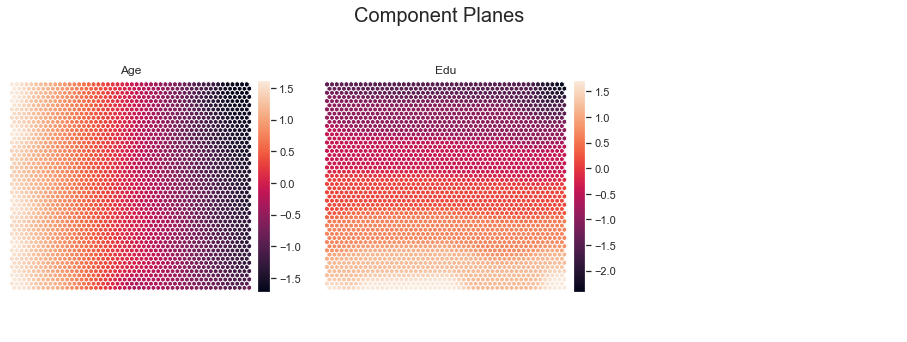

In [59]:
# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

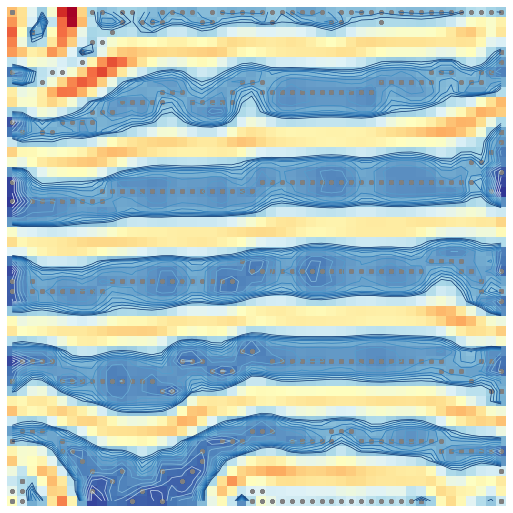

In [60]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=True, 
    contooor=True, # Visualize isomorphic curves
    blob=False
)

#UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values 

In [61]:
#Obtaining SOM's BMUs labels
Demo_SOM = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1), 
                             index=df.index, 
                             columns=np.append(df[Demographic].columns,"SOM Labels- Demo"))

In [62]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = Demo_SOM.groupby("SOM Labels- Demo").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=som_units, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

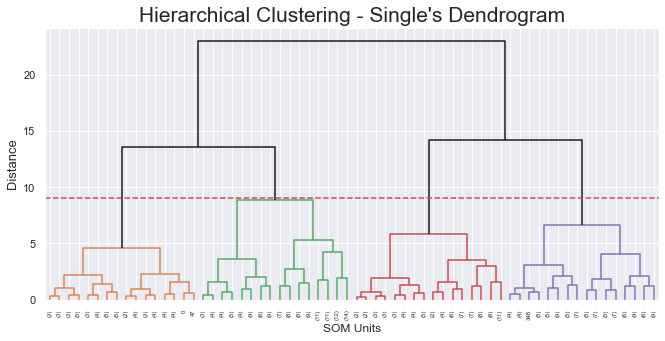

In [63]:
#Hierarchical clustering 
Z= linkage(som_units, method='ward')

sns.set()
fig = plt.figure(figsize=(11,5))

# Dendrogram 
dendrogram(Z, truncate_mode='level', p=5, color_threshold=9, above_threshold_color='k')
plt.hlines(9, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Single\'s Dendrogram', fontsize=21)
plt.xlabel('SOM Units')
plt.ylabel('Distance', fontsize=13)
plt.show()

In [64]:
# Perform Hierarchical clustering
hierclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
nodeclus_labels = hierclust.fit_predict(som_units)


In [65]:
# Obtaining HC labels for each SOM unit
hc_som_units = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(nodeclus_labels,1)), axis=1),
index=som_units.index, columns=np.append(som_units.columns,["SOM Labels Demo HC 3"]))

# Get cluster labels for each observation
df_final_b = Demo_SOM.merge(right=hc_som_units.loc[:,"SOM Labels Demo HC 3"],
left_on="SOM Labels- Demo", right_index=True).sort_index()
df_final_b

Age       Edu  SOM Labels- Demo  SOM Labels Demo HC 3
0     0.404699  1.738847            2482.0                   1.0
1     1.564676  0.668523            1948.0                   1.0
2    -1.741259 -2.542450               0.0                   0.0
3    -0.349286 -0.401802             919.0                   0.0
4    -0.059292 -0.401802             924.0                   0.0
...        ...       ...               ...                   ...
9951  0.520697  1.738847            2483.0                   1.0
9952  1.042686 -0.936964             392.0                   0.0
9953 -1.741259 -2.542450               0.0                   0.0
9954 -0.871276 -0.401802             910.0                   0.0
9955  0.404699 -0.401802             882.0                   0.0

[9956 rows x 4 columns]

In [66]:
# Number of observations in each cluster
df_final_b['SOM Labels Demo HC 3'].value_counts()

0.0    4932
1.0    2720
2.0    2304
Name: SOM Labels Demo HC 3, dtype: int64

In [67]:
sst = get_ss(df_final_b.drop(columns=['SOM Labels Demo HC 3'])) 
ssw_labels = df_final_b[df_final_b.drop(columns=['SOM Labels Demo HC 3']).columns.to_list() + ["SOM Labels Demo HC 3"]].groupby(by='SOM Labels Demo HC 3').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.7532930069384649

In [68]:
# Characterizing the final clusters
clusters_Demo= df_final_b.drop(columns="SOM Labels- Demo").groupby("SOM Labels Demo HC 3").mean()
clusters_Demo

Age       Edu
SOM Labels Demo HC 3                    
0.0                  -0.157580 -0.848747
1.0                   0.911912  0.798575
2.0                  -0.739243  0.874086

In [69]:
#Plot for each cluster the average values of each variable in in this perspective
sns.set()
plt.figure(figsize=(10,10))

colors = ["g","r","c","b",'y']
for value in range(0,3):
    plt.plot(clusters_Demo.columns,clusters_Demo.loc[value, clusters_Demo.columns], color=colors[value], linewidth=4, label='Cluster'+ str(value))
plt.legend(prop={'size':20})
plt.title('Perspective Demographic - Cluster\'s means representation', fontsize=20)
#plt.savefig(os.path.join(os.getcwd(), 'figures', 'exp_analysis', 'Clusters_means_ClientValue.png'), dpi=200)
plt.show()

In [70]:
def _color_red_or_green(val):
    if val <= 0.4:
        color = 'background-color: mistyrose'
    elif val > 0.4 and val <= 0.65:
        color = 'background-color: darksalmon'
    else:
        color = 'background-color: tomato'  

    return color

In [71]:
clusters_Demo = clusters_Demo.style.applymap(_color_red_or_green)
clusters_Demo


### Products - Dryred,Sweetred,Drywh,Sweetwh,Dessert, Exotic,Accessories


### Products Perspective

In [72]:
Products = ['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic','Accessories']


SOM + Hierachical CLustering

In [73]:
#Set the random seed
np.random.seed(42)

#Perform the SOM
sm = sompy.SOMFactory().build(
    df[Products].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=Products
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)



 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.671000, quantization error: 1.664352

 epoch: 2 ---> elapsed time:  0.512000, quantization error: 2.369602

 epoch: 3 ---> elapsed time:  0.446000, quantization error: 2.337311

 epoch: 4 ---> elapsed time:  0.429000, quantization error: 2.324784

 epoch: 5 ---> elapsed time:  0.455000, quantization error: 2.318782

 epoch: 6 ---> elapsed time:  0.650000, quantization error: 2.309744

 epoch: 7 ---> elapsed time:  0.583000, quantization error: 2.304057

 epoch: 8 ---> elapsed time:  0.656000, quantization error: 2.302003

 epoch: 9 ---> elapsed time:  0.626000, quantization error: 2.300394

 epoch: 10 ---> elapsed time:  0.461000, quantization error: 2.298861

 epoch: 11 ---> elapsed time:  0.488000, quantization error: 2.297354

 epoch: 12 ---> elapsed time:  0.469000, quantization error: 2.295840

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  0.408000, quantization error: 1.605485

 epoch: 15 ---> elapsed time:  0.400000, quantization error: 1.598382

 epoch: 16 ---> elapsed time:  0.429000, quantization error: 1.591395

 epoch: 17 ---> elapsed time:  0.448000, quantization error: 1.584347

 epoch: 18 ---> elapsed time:  0.617000, quantization error: 1.577217

 epoch: 19 ---> elapsed time:  0.510000, quantization error: 1.570099

 epoch: 20 ---> elapsed time:  0.629000, quantization error: 1.562967

 epoch: 21 ---> elapsed time:  0.486000, quantization error: 1.555766

 epoch: 22 ---> elapsed time:  0.405000, quantization error: 1.548380

 epoch: 23 ---> elapsed time:  0.670000, quantization error: 1.541014

 epoch: 24 ---> elapsed time:  0.454000, quantization error: 1.533447

 epoch: 25 ---> elapsed time:  0.520000, quantization error: 1.525688

 epoch: 26 ---> elapsed time:  0.464000, quantization error: 1.517156

 epoch: 27 ---> elapsed time:  0.461000, quantization error: 1.508240

 epoch

In [74]:
# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

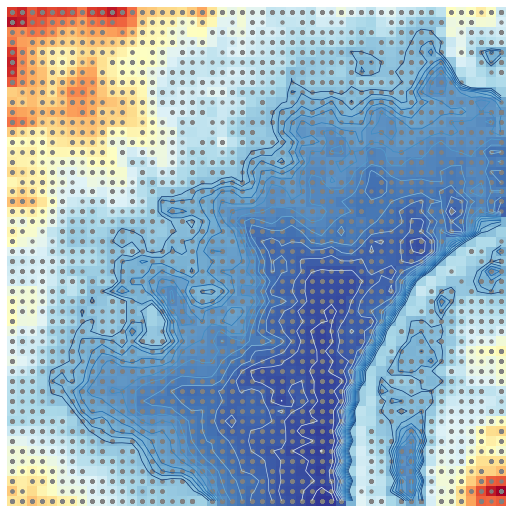

In [75]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=True, 
    contooor=True, # Visualize isomorphic curves
    blob=False
)

#UMAT[1]  # U-matrix values - no colorscale so we have to rely on the values 

In [76]:
#Obtaining SOM's BMUs labels
Prod_SOM = pd.DataFrame(np.concatenate((sm._data, np.expand_dims(sm._bmu[0],1)), axis=1), 
                             index=df.index, 
                             columns=np.append(df[Products].columns,"SOM Labels- Prod"))

In [77]:
# Getting the centroids of each cluster given by the BMUs of each observation
som_units = Prod_SOM.groupby("SOM Labels- Prod").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=som_units, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [78]:
#Hierarchical clustering 
Z= linkage(som_units, method='ward')

sns.set()
fig = plt.figure(figsize=(11,5))

# Dendrogram 
dendrogram(Z, truncate_mode='level', p=5, color_threshold=9, above_threshold_color='k')
plt.hlines(9, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Ward\'s Dendrogram', fontsize=21)
plt.xlabel('SOM Units')
plt.ylabel('Distance', fontsize=13)
plt.show()

In [79]:
# Perform Hierarchical clustering
hierclust = AgglomerativeClustering(n_clusters=2, linkage='ward')
nodeclus_labels = hierclust.fit_predict(som_units)


In [80]:
# Obtaining HC labels for each SOM unit
hc_som_units = pd.DataFrame(np.concatenate((som_units.values, np.expand_dims(nodeclus_labels,1)), axis=1),
index=som_units.index, columns=np.append(som_units.columns,["SOM Labels Prod HC 3"]))

# Get cluster labels for each observation
df_final_c = Prod_SOM.merge(right=hc_som_units.loc[:,"SOM Labels Prod HC 3"],
left_on="SOM Labels- Prod", right_index=True).sort_index()
df_final_c

Dryred  Sweetred     Drywh   Sweetwh   Dessert    Exotic  Accessories  \
0     0.704607 -0.389663 -0.204099 -0.639539 -0.769757 -0.902661    -0.429311   
1    -0.066430 -0.909875  1.386139 -0.767437 -0.507090 -0.961207     0.680972   
2    -1.994023  2.861664 -1.158242  3.197387  1.856911  1.848990    -0.429311   
3     1.518480 -0.779822 -1.396777 -0.767437 -0.769757  2.258811    -0.429311   
4     1.475644 -0.909875 -1.317265 -0.639539 -0.769757  0.678075    -0.429311   
...        ...       ...       ...       ...       ...       ...          ...   
9951  1.175796 -0.909875 -0.681170 -0.767437 -0.769757 -0.317203     0.495925   
9952 -0.880303  0.650762  0.591020  0.383641  0.674911 -0.200112    -0.429311   
9953 -1.908352  2.211398 -1.476289  3.964772  1.988245  1.439170    -0.429311   
9954 -1.394328  0.780815  1.306628  0.511539  0.806244 -0.200112    -0.429311   
9955  0.533265  0.390656 -1.237753  0.511539 -0.507090 -0.727024    -0.429311   

      SOM Labels- Prod  SOM Labels Prod HC 3  
0               1381.0                   1.0  
1               1299.0                   1.0  
2                 58.0                   0.0  
3               2464.0                   1.0  
4               2470.0                   1.0  
...                ...                   ...  
9951            1987.0                   1.0  
9952             379.0                   0.0  
9953              58.0                   0.0  
9954              28.0                   0.0  
9955            1270.0                   1.0  

[9956 rows x 9 columns]

In [81]:
# Number of observations in each cluster
df_final_c['SOM Labels Prod HC 3'].value_counts()

1.0    6497
0.0    3459
Name: SOM Labels Prod HC 3, dtype: int64

In [82]:
# using R^2
sst = get_ss(df_final_c.drop(columns=['SOM Labels Prod HC 3']))  
ssw_labels = df_final_c[df_final_c.drop(columns=['SOM Labels Prod HC 3']).columns.to_list() + ["SOM Labels Prod HC 3"]].groupby(by='SOM Labels Prod HC 3').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.5865316786322804

In [83]:
# Characterizing the final clusters
clusters_prod= df_final_c.drop(columns="SOM Labels- Prod").groupby("SOM Labels Prod HC 3").mean()
clusters_prod

Dryred  Sweetred     Drywh   Sweetwh   Dessert  \
SOM Labels Prod HC 3                                                     
0.0                  -1.011731  0.751413  0.548219  0.694345  0.727231   
1.0                   0.538645 -0.400052 -0.291871 -0.369669 -0.387178   

                        Exotic  Accessories  
SOM Labels Prod HC 3                         
0.0                   0.191937    -0.308059  
1.0                  -0.102187     0.164011

KeyError: 2.0

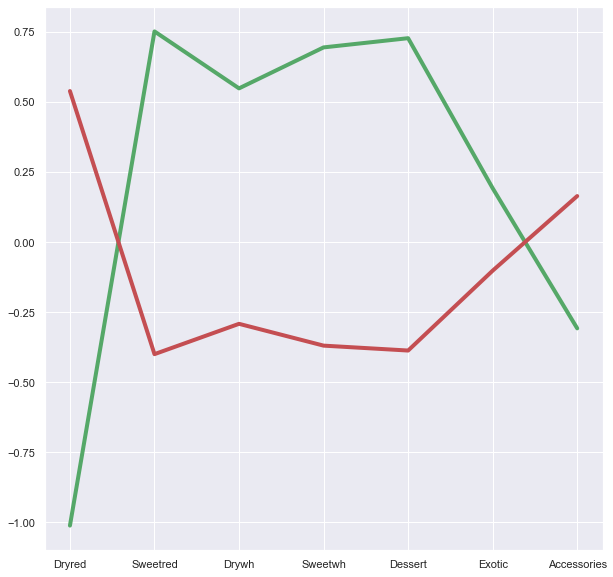

In [84]:
#Plot for each cluster the average values of each variable in in this perspective
sns.set()
plt.figure(figsize=(10,10))

colors = ["g","r","c","b",'y']
for value in range(0,3):
    plt.plot(clusters_prod.columns,clusters_prod.loc[value, clusters_prod.columns], color=colors[value], linewidth=4, label='Cluster'+ str(value))
plt.legend(prop={'size':20})
plt.title('Perspective Products - Cluster\'s means representation', fontsize=20)
#plt.savefig(os.path.join(os.getcwd(), 'figures', 'exp_analysis', 'Clusters_means_ClientValue.png'), dpi=200)
plt.show()

In [85]:
def _color_red_or_green(val):
    if val <= 0.4:
        color = 'background-color: mistyrose'
    elif val > 0.4 and val <= 0.65:
        color = 'background-color: darksalmon'
    else:
        color = 'background-color: tomato'  

    return color

In [86]:
clusters_prod = clusters_prod.style.applymap(_color_red_or_green)
clusters_prod

### Final cluster solution

In [145]:
#Create a dataframe concating all the perspectives 
df_final= pd.concat([df_final_a, df_final_b,df_final_c], axis=1)
df_final

Dayswus  Monetary   Recency  WebVisit  SOM Labels- Client Value  \
0    -1.210125  0.313276 -0.635905 -0.090622                    1826.0   
1     0.707111  1.902241 -0.420569 -0.519646                    1249.0   
2    -1.145888 -0.905550 -0.090388  1.196447                    1100.0   
3     0.746642 -0.908647 -0.233945  0.767424                     678.0   
4    -0.300920 -0.910196 -0.851240  0.338401                    1409.0   
...        ...       ...       ...       ...                       ...   
9951  1.156772  0.235841 -0.047321 -0.519646                    1093.0   
9952 -1.491781  0.149114 -0.248301 -1.377692                    2318.0   
9953 -1.378130 -0.893160  0.038813 -0.090622                    2153.0   
9954  1.033239 -0.942718  4.388591  0.338401                       5.0   
9955  0.400748  0.811957 -0.492348 -0.090622                    1432.0   

      SOM Labels Client Value HC 3       Age       Edu  SOM Labels- Demo  \
0                              0.0  0.404699  1.738847            2482.0   
1                              1.0  1.564676  0.668523            1948.0   
2                              0.0 -1.741259 -2.542450               0.0   
3                              0.0 -0.349286 -0.401802             919.0   
4                              0.0 -0.059292 -0.401802             924.0   
...                            ...       ...       ...               ...   
9951                           0.0  0.520697  1.738847            2483.0   
9952                           1.0  1.042686 -0.936964             392.0   
9953                           0.0 -1.741259 -2.542450               0.0   
9954                           2.0 -0.871276 -0.401802             910.0   
9955                           0.0  0.404699 -0.401802             882.0   

      SOM Labels Demo HC 3    Dryred  Sweetred     Drywh   Sweetwh   Dessert  \
0                      1.0  0.704607 -0.389663 -0.204099 -0.639539 -0.769757   
1                      1.0 -0.066430 -0.909875  1.386139 -0.767437 -0.507090   
2                      0.0 -1.994023  2.861664 -1.158242  3.197387  1.856911   
3                      0.0  1.518480 -0.779822 -1.396777 -0.767437 -0.769757   
4                      0.0  1.475644 -0.909875 -1.317265 -0.639539 -0.769757   
...                    ...       ...       ...       ...       ...       ...   
9951                   1.0  1.175796 -0.909875 -0.681170 -0.767437 -0.769757   
9952                   0.0 -0.880303  0.650762  0.591020  0.383641  0.674911   
9953                   0.0 -1.908352  2.211398 -1.476289  3.964772  1.988245   
9954                   0.0 -1.394328  0.780815  1.306628  0.511539  0.806244   
9955                   0.0  0.533265  0.390656 -1.237753  0.511539 -0.507090   

        Exotic  Accessories  SOM Labels- Prod  SOM Labels Prod HC 3  
0    -0.902661    -0.429311            1381.0                   1.0  
1    -0.961207     0.680972            1299.0                   1.0  
2     1.848990    -0.429311              58.0                   0.0  
3     2.258811    -0.429311            2464.0                   1.0  
4     0.678075    -0.429311            2470.0                   1.0  
...        ...          ...               ...                   ...  
9951 -0.317203     0.495925            1987.0                   1.0  
9952 -0.200112    -0.429311             379.0                   0.0  
9953  1.439170    -0.429311              58.0                   0.0  
9954 -0.200112    -0.429311              28.0                   0.0  
9955 -0.727024    -0.429311            1270.0                   1.0  

[9956 rows x 19 columns]

In [146]:
#Calculate the centroids of each combination according to the clusters in each pespective
df_centroids=df_final.groupby(by=['SOM Labels Client Value HC 3','SOM Labels Demo HC 3','SOM Labels Prod HC 3']).mean()
df_centroids

Dayswus  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                   0.005712   
                                                  1.0                   0.073563   
                             1.0                  0.0                  -0.072251   
                                                  1.0                   0.012930   
                             2.0                  0.0                  -0.030838   
                                                  1.0                   0.037745   
1.0                          0.0                  0.0                  -0.030658   
                                                  1.0                  -0.140848   
                             1.0                  0.0                   0.030842   
                                                  1.0                  -0.075044   
                             2.0                  0.0                   0.296981   
                                                  1.0                   0.422161   
2.0                          0.0                  0.0                  -0.250201   
                                                  1.0                  -0.293218   
                             1.0                  1.0                  -0.845173   
                             2.0                  0.0                  -0.084292   
                                                  1.0                  -0.095834   

                                                                        Monetary  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                  -0.643762   
                                                  1.0                  -0.297171   
                             1.0                  0.0                   0.138440   
                                                  1.0                   0.213912   
                             2.0                  0.0                  -0.777274   
                                                  1.0                  -0.611498   
1.0                          0.0                  0.0                   1.194208   
                                                  1.0                   1.378109   
                             1.0                  0.0                   1.237887   
                                                  1.0                   1.372376   
                             2.0                  0.0                   0.796470   
                                                  1.0                   0.486730   
2.0                          0.0                  0.0                  -0.942630   
                                                  1.0                  -0.939712   
                             1.0                  1.0                  -0.936966   
                             2.0                  0.0                  -0.941727   
                                                  1.0                  -0.939958   

                                                                         Recency  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                  -0.181569   
                                                  1.0                  -0.173979   
                             1.0                  0.0                  -0.193749   
                                                  1.0                  -0.163808   
                             2.0                  0.0                  -0.157401   
                                                  1.0                  -0.177045   
1.0                          0.0                  0.0                  -0.205064   
                                                  1.0                  -0.146362   
                             1.0       

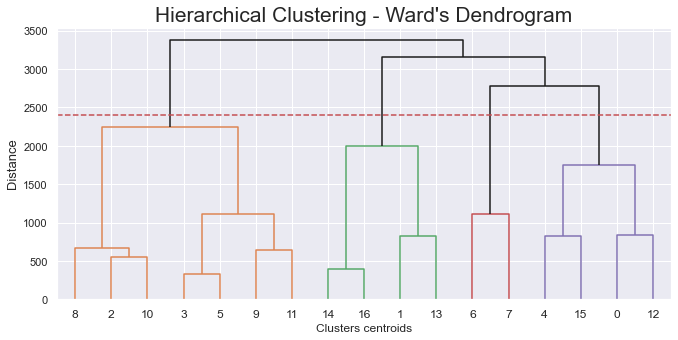

In [147]:
#Hierarchical clustering 
Z= linkage(df_centroids, method='ward')

sns.set()
fig = plt.figure(figsize=(11,5))

# Dendrogram 
dendrogram(Z, truncate_mode='level', p=5, color_threshold=2400, above_threshold_color='k')
plt.hlines(2400, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - Ward\'s Dendrogram', fontsize=21)
plt.xlabel('Clusters centroids')
plt.ylabel('Distance', fontsize=13)
plt.show()

In [167]:
#Hierarchical clustering for the final clusters 
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['Clusters'] = hclust_labels
df_centroids 

Dayswus  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                   0.005712   
                                                  1.0                   0.073563   
                             1.0                  0.0                  -0.072251   
                                                  1.0                   0.012930   
                             2.0                  0.0                  -0.030838   
                                                  1.0                   0.037745   
1.0                          0.0                  0.0                  -0.030658   
                                                  1.0                  -0.140848   
                             1.0                  0.0                   0.030842   
                                                  1.0                  -0.075044   
                             2.0                  0.0                   0.296981   
                                                  1.0                   0.422161   
2.0                          0.0                  0.0                  -0.250201   
                                                  1.0                  -0.293218   
                             1.0                  1.0                  -0.845173   
                             2.0                  0.0                  -0.084292   
                                                  1.0                  -0.095834   

                                                                        Monetary  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                  -0.643762   
                                                  1.0                  -0.297171   
                             1.0                  0.0                   0.138440   
                                                  1.0                   0.213912   
                             2.0                  0.0                  -0.777274   
                                                  1.0                  -0.611498   
1.0                          0.0                  0.0                   1.194208   
                                                  1.0                   1.378109   
                             1.0                  0.0                   1.237887   
                                                  1.0                   1.372376   
                             2.0                  0.0                   0.796470   
                                                  1.0                   0.486730   
2.0                          0.0                  0.0                  -0.942630   
                                                  1.0                  -0.939712   
                             1.0                  1.0                  -0.936966   
                             2.0                  0.0                  -0.941727   
                                                  1.0                  -0.939958   

                                                                         Recency  \
SOM Labels Client Value HC 3 SOM Labels Demo HC 3 SOM Labels Prod HC 3             
0.0                          0.0                  0.0                  -0.181569   
                                                  1.0                  -0.173979   
                             1.0                  0.0                  -0.193749   
                                                  1.0                  -0.163808   
                             2.0                  0.0                  -0.157401   
                                                  1.0                  -0.177045   
1.0                          0.0                  0.0                  -0.205064   
                                                  1.0                  -0.146362   
                             1.0       

In [168]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['Clusters'].to_dict()

df_ = df_final.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_clusters'] = df_.apply(
    lambda row: cluster_mapper[
        (row['SOM Labels Client Value HC 3'], row['SOM Labels Demo HC 3'],row['SOM Labels Prod HC 3'])
    ], axis=1
)

# Merged cluster centroids
merged_clusters = df_.groupby('merged_clusters').mean()

In [169]:
# Number of observations in each cluster
df_['merged_clusters'].value_counts()

0    4364
2    2313
1    2251
3    1028
Name: merged_clusters, dtype: int64

In [170]:
# using R^2
sst = get_ss(df_.drop(columns=['merged_clusters']))  
ssw_labels = df_[df_.drop(columns=['merged_clusters']).columns.to_list() + ["merged_clusters"]].groupby(by='merged_clusters').apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.41122720019802367

In [171]:
def _color_red_or_green(val):
    if val <= 0.4:
        color = 'background-color: mistyrose'
    elif val > 0.4 and val <= 0.65:
        color = 'background-color: darksalmon'
    else:
        color = 'background-color: tomato'  

    return color

In [172]:
merged_clusters.drop(columns = ['SOM Labels- Prod','SOM Labels Prod HC 3','SOM Labels Demo HC 3','SOM Labels- Demo','SOM Labels Client Value HC 3','SOM Labels- Client Value'],inplace = True)

In [173]:
merged_clusters = merged_clusters.style.applymap(_color_red_or_green)
merged_clusters

### Categorical variables

Intrepertation of the categorical variables

In [174]:
num_cat = pd.concat([df_,df_categorical],axis=1)


In [175]:
num_cat.groupby('merged_clusters').mean()['Complain']

merged_clusters
0    0.010999
1    0.010662
2    0.012538
3    0.010700
Name: Complain, dtype: float64

In [176]:
num_cat.groupby('merged_clusters').mean()['Mailfriend']

merged_clusters
0    0.094409
1    0.094625
2    0.137484
3    0.062257
Name: Mailfriend, dtype: float64

In [177]:
num_cat.groupby('merged_clusters').mean()['Emailfriend']

merged_clusters
0    0.039643
1    0.068858
2    0.075227
3    0.001946
Name: Emailfriend, dtype: float64

In [178]:
num_cat.groupby('merged_clusters').mean()['Dependents']

merged_clusters
0    0.668882
1    0.804976
2    0.910073
3    0.184825
Name: Dependents, dtype: float64